In [2]:
!pip install matplotlib tqdm opencv-python

In [1]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm import tqdm
%matplotlib inline

In [2]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01
epochs=5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_batch_size = 16
test_batch_size = 16

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import torchvision.transforms as T

START_seed()
# Define your transformations (hint:use augmentations)

tranform_train = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

In [5]:
#prep the train, validation and test dataset
torch.manual_seed(2022)

data_dir = "data/"

train = CIFAR10(data_dir, train=True, download=True, transform=tranform_train)

tr_100 = torch.utils.data.Subset(train, range(10000))

print(len(train))

val_size = 10000
train_size = len(train) - val_size
train, val = random_split(train, [train_size, val_size])

print(len(train), len(val))

test = CIFAR10(data_dir, train=False, download=True, transform=tranform_test)

#  train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=10, shuffle=True, num_workers=1)
val_loader = DataLoader(val, batch_size=train_batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test, batch_size=train_batch_size, shuffle=False, num_workers=8)

print(len(train_loader), len(val_loader), len(test_loader))


Files already downloaded and verified
50000
40000 10000
Files already downloaded and verified
4000 625 625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


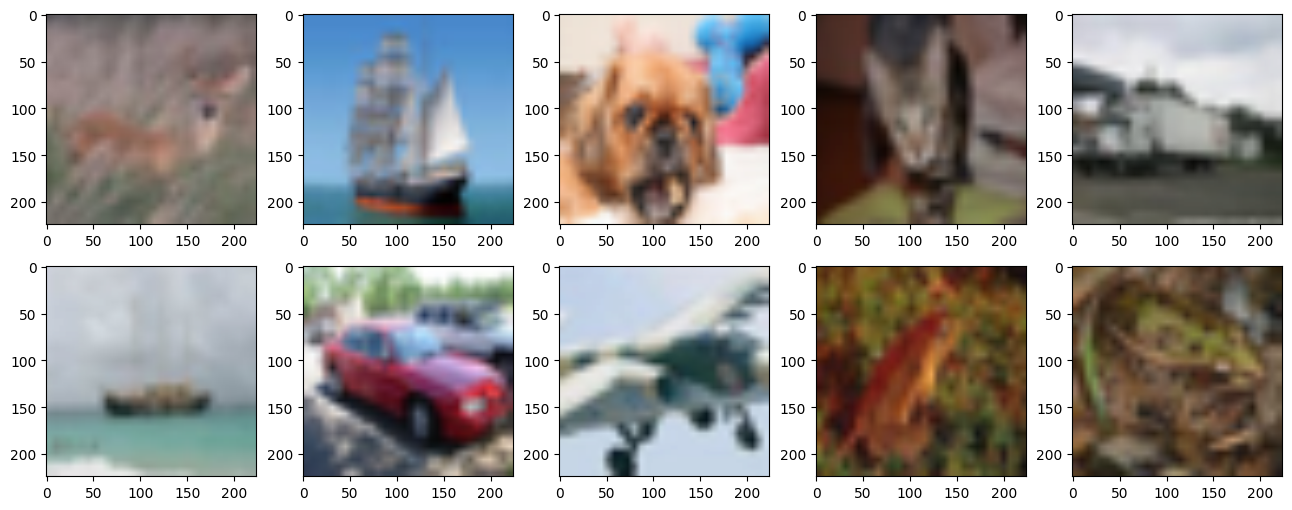

In [6]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

In [7]:
START_seed()
import torchvision.models as models

#models you can use Resnet-18, VGG-16, Resnet-50. Also dont forget to change the last layer output classes
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
#print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

Number of parameters: 11181642


/apps/local/shared/CV701_Fall23/CV701_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/local/shared/CV701_Fall23/CV701_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) 

In [9]:
# ## Creating training loop
def train(modello):    
    running_loss = 0.0    

    modello.train()

    pbar = tqdm(total=len(train_loader))
    
    for batch, data in enumerate(train_loader, 0):       

        pbar.update(1)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data        

        # zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward + optimize
        outputs = model(inputs.to(device))        
        loss = criterion(outputs, labels.to(device))     
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        
        # Postfix will be displayed on the right,
        # formatted automatically based on argument's datatype
        pbar.set_postfix(loss=running_loss/(batch+1), lr=optimizer.param_groups[0]['lr'])
       
        #print(f'[{batch + 1}, {i + 1:5d}] loss: {running_loss / (batch+1):.3f}')
        #running_loss = 0.0   

In [10]:
def validate(model):       
    running_loss = 0.0    

    model.eval()

    total = 0
    correct = 0

    tmpenum = enumerate(val_loader, 0)

    pbar = tqdm(tmpenum, total=len(val_loader))


    for i, data in tmpenum:

        pbar.update(1)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data     

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))  

        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:                                
                correct +=1            
            total+=1                       
        running_loss += loss.item()        

        pbar.set_postfix(loss=running_loss/(i+1))        

        
    print('Val loss: {:.4f} accuracy: {:.4f}'.format(loss/(i+1), 100.*correct/total))    

In [11]:
# move model to GPU
model.to(device)
start = time.time()
for epoch in range(0, epochs):
    print("Epoch number: {0}".format(epoch))
    train(model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

Epoch number: 0


100%|██████████| 625/625 [00:08<00:00, 69.96it/s, loss=1.31]


Val loss: 0.0017 accuracy: 52.4200
Epoch number: 1


100%|██████████| 625/625 [00:09<00:00, 67.58it/s, loss=0.983]


Val loss: 0.0011 accuracy: 65.7200
Epoch number: 2


100%|██████████| 625/625 [00:09<00:00, 68.04it/s, loss=0.789]


Val loss: 0.0009 accuracy: 72.9100
Epoch number: 3


100%|██████████| 625/625 [00:09<00:00, 63.64it/s, loss=0.676]


Val loss: 0.0010 accuracy: 76.8700
Epoch number: 4


100%|██████████| 625/625 [00:09<00:00, 67.71it/s, loss=0.637]

Val loss: 0.0012 accuracy: 78.5100
Total training and inference time is: 497.0444037914276


In [14]:
def new_train(model, epochs=10):    

    for e in range(epochs):
        pbar = tqdm(            
            unit="batches",
            ascii=True,
            dynamic_ncols=True,        
        )
        loss_epoch = 0
        pbar.set_description(f"Running epoch {e + 1}/{epochs}")
        
        model.train()

        for idx, batch in enumerate(pbar):
            if isinstance(batch, list):
                batch = [b.to(device) for b in batch]

            optimizer.zero_grad()            

            model_out = model(batch)
            loss = criterion(model_out, batch["label"].to(device))

            loss.backward()
            optimizer.step()            

            for m in self.metrics:
                m(model_out, batch, Stage.train, self.device)

            running_train = {
                "train_" + m.name: m.reduce(Stage.train) for m in self.metrics
            }

            running_train.update({"train_loss": loss_epoch / (idx + 1)})

            loss_epoch += loss.item()
            pbar.set_postfix(**running_train)

            if self.debug and idx > 10:
                break

        pbar.close()

        train_metrics = {
            "train_" + m.name: m.reduce(Stage.train, True) for m in self.metrics
        }
        train_metrics.update({"train_loss": loss_epoch / (idx + 1)})

        if "val" in datasets:
            val_metrics = self.validate()
            if self.accelerator.is_local_main_process:
                self.checkpointer(
                    self,
                    e,
                    train_metrics,
                    val_metrics,
                    lambda x: self.accelerator.unwrap_model(x),
                )
        else:
            val_metrics = train_metrics.update(
                {"val_loss": loss_epoch / (idx + 1)}
            )

        if e >= 1 and self.debug:
            break